# Nonprobabilistic Linear Classification

Linear classification refers to a fitting process where decision boundary can be described by **general linear function**. Usually it does not mean the decision boundary is a line, but with a form of general linear function $y(\boldsymbol{x}) = \boldsymbol{w}^T\boldsymbol{\phi(x)}$. But more often than not, it has the form:

$$
y(\boldsymbol{x}) = f(\boldsymbol{w}^T\boldsymbol{x} + w_0)
$$

where $f()$ is a nonlinear function and defined as **activation function**.

To do classfication, there are usually two ways: 

1. Nonprobabilistic method, depending on discriminant function without probability, which only tells us an effectively binary results
2. Probabilistic method including generative model and discrimitive model, which can yield probability of the observation if it belongs to some classes

Here we focus on **Nonprobabilistic method**, and more specically, **least squares method** and **Fisher's linear discriminant**.

## 1. Least squares
### Algebra
Least squares method is a natural extension from linear regression. For simplicity, the activation function is set as also a linear function, therefore, the decision boundary can be described as:

$$
y(\boldsymbol{x}) = \boldsymbol{w}^T\boldsymbol{x} + w_0
$$

One hot encoding is applied to present $y$. For instance, if there are 3 class, and the observation $\boldsymbol{x}_s$ belongs to Class 2, then $\boldsymbol{y}_s = (0,1,0)$. It can also described as:

$$
y_k(\boldsymbol{x}) = \boldsymbol{w}_k^T\boldsymbol{x} + w_{k0}
$$

or 

$$
\boldsymbol{y}(\boldsymbol{x}) = \widetilde{\boldsymbol{W}}^T\widetilde{\boldsymbol{x}}
$$

Note here that the bias is absorbe into the matrix $\widetilde{\boldsymbol{W}}$ (a D+1 by K matrix where K is the number of classes), therefore, if originally $\boldsymbol{x}$ is a D-dim vector, now it should be (D+1)-dim vector with an additional dummy input $x_0=1$, i.e. $\widetilde{\boldsymbol{x}} = (1, \boldsymbol{x})$.

By doing algebra very similar to that in the case of linear regression, it can be found that

$$
\widetilde{\boldsymbol{W}} = (\widetilde{\boldsymbol{X}}^T\widetilde{\boldsymbol{X}})^{-1}\widetilde{\boldsymbol{X}}^T\boldsymbol{T}
$$

where $\boldsymbol{X}$ is a N by D+1 matrix and $\boldsymbol{T}$ is a N by K matrix, then we will have

$$
\boldsymbol{y}(\boldsymbol{x}) = \widetilde{\boldsymbol{W}}^T\boldsymbol{x}
$$

After $\widetilde{\boldsymbol{W}}^T$ has been calculated, **we classify $\boldsymbol{x}$ into the class k if $y_k(\boldsymbol{x})$ has the biggest values**. Note that the sum of each element of vector $\boldsymbol{y}(\boldsymbol{x})$ will be one, i.e. $\sum_{k=1}^{K}y_k=1$, if one hot encoding is used. BUT, this does not mean $y_k$ can be interpreted as probability, because it can be negative or larger than 1 (see the bar plot in **Simulation** section).

From simulation, it should be noted that least squares method is **very sensitive to outliers** which will distract the decision boundary.


### Simulation

In [291]:
import numpy as np
import matplotlib.pyplot as plt  

NUM_C = 50
NUM_OUTLIERS = 15

C_1 = np.random.multivariate_normal([-1,1], [[3,1],[1,1]] , NUM_C)
C_2 = np.random.multivariate_normal([0,-3], [[1,0],[0,1]] , NUM_C - NUM_OUTLIERS)
C_2_outliers = np.random.multivariate_normal([2,-15], [[0.5,0],[0,0.5]] , NUM_OUTLIERS)
C_2_expanded = np.concatenate((C_2, C_2_outliers))

C_1 = np.concatenate((C_1, np.ones((NUM_C, 1))), axis = 1)
C_2 = np.concatenate((C_2, np.ones((NUM_C - NUM_OUTLIERS, 1))), axis = 1)
C_2_expanded = np.concatenate((C_2_expanded, np.ones((NUM_C, 1))), axis = 1)

T_1 = np.array([[1, 0]] * NUM_C)
T_2 = np.array([[0, 1]] * (NUM_C - NUM_OUTLIERS))
T_2_expanded = np.array([[0,1]] * NUM_C)

def fitting_plot(C_1, C_2, T_1, T_2, ax):
    T = np.concatenate((T_1, T_2))
    C = np.concatenate((C_1, C_2))
    W = np.linalg.inv(C.T.dot(C)).dot(C.T).dot(T)
    minx = min(C_1.T[0].min(), C_2.T[0].min())
    maxx = max(C_1.T[0].max(), C_2.T[0].max())
    X = np.arange(minx, maxx, 0.1)
    Y = -W[0][0] / W[1][0] * X + (0.5 - W[2][0]) / W[1][0] 
    ax.plot(X, Y, linestyle = 'dashed', color = "r", linewidth = 2)
    ax.scatter(C_1.T[0], C_1.T[1], s = 100, alpha = 0.6)
    ax.scatter(C_2.T[0], C_2.T[1], s = 100, alpha = 0.6)
    ax.set_xlim(minx, maxx)    
    
    return C.dot(W)
     


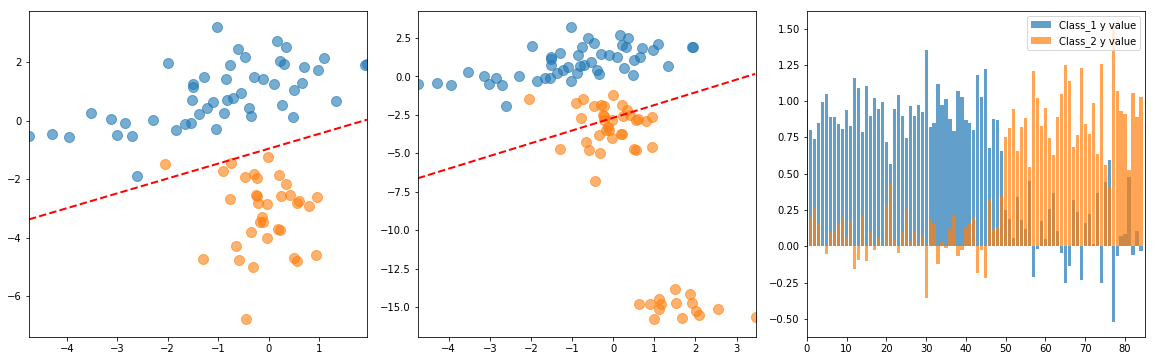

In [292]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))
plt.subplots_adjust(wspace = 0.15)
Y_1 = fitting_plot(C_1, C_2, T_1, T_2, axes[0])
Y_2 = fitting_plot(C_1, C_2_expanded, T_1, T_2_expanded, axes[1])
axes[2].bar(np.arange(len(Y_1)), Y_1.T[0], alpha = 0.7)
axes[2].bar(np.arange(len(Y_1)), Y_1.T[1], alpha = 0.7)
axes[2].set_xlim(0, len(Y_1))
_ = axes[2].legend(["Class_1 y value", "Class_2 y value"])

## 2. Fisher's linear discriminant
### Algebra
Fisher's linear distriminant requires more algebra and the key is **Fisher criterion**. It is a dimension reduction method. 
1. The first step is to project data points to a lower dimentional space; and the projection diretion $\boldsymbol{w}$ is what should be determined.
2. The second step is usually to determine a threhold (Fisher criterion) in the projected space.
Therefore to make it efficient, the data should be **well separated** in a lower dimentional space.

For simplicity, we first discuss the two-class problem.

Our goal is to determine $\boldsymbol{w}$ and after project, we will have $y = \boldsymbol{w}^T\boldsymbol{x}$. We define the "mass center" of two classes as:

$$
\boldsymbol{m}_1 = \frac{1}{N_1}\sum_{n\in C_1}\boldsymbol{x}_n,\ 
\boldsymbol{m}_2 = \frac{1}{N_2}\sum_{n\in C_2}\boldsymbol{x}_n
$$

Having projected the "mass centers" into the lower dimensional space:

$$
m_k \equiv m_2-m_1 = \boldsymbol{w}^T(\boldsymbol{m}_2-\boldsymbol{m}_1)
$$

In the projected space, we could define the within-class (**total**) variance:

$$
s_k^2 = \sum_{n\in C_k}(y_n-m_k)^2
$$

Then the value we would like to maximize is 

$$
J(\boldsymbol{w})=\frac{(m_1-m_2)^2}{s_1^2+s_2^2}
$$

Or to be more concise by defining **between-class** covariance
$S_B=(\boldsymbol{m_1}-\boldsymbol{m_2})(\boldsymbol{m_1}-\boldsymbol{m_2})^T$ and total **within-class** covariance 
$S_W=\sum_{k=1}^{K}\sum_{n\in C_k}(\boldsymbol{x}_n-\boldsymbol{m}_k)(\boldsymbol{x}_n-\boldsymbol{m}_k)^T$, then we will have:

$$
J(\boldsymbol{w})=\frac{\boldsymbol{w}^TS_B\boldsymbol{w}}{\boldsymbol{w}^TS_W\boldsymbol{w}}
$$

Diffrentiating $J(\boldsymbol{w})$ with respect to $\boldsymbol{w}$, we will have:

$$
(\boldsymbol{w}^TS_B\boldsymbol{w})S_W\boldsymbol{w} =
(\boldsymbol{w}^TS_W\boldsymbol{w})S_B\boldsymbol{w}
$$

$\boldsymbol{w}^TS_B\boldsymbol{w}$ or $\boldsymbol{w}^TS_W\boldsymbol{w}$ are just some constants. By the definition of $S_B$, $S_B\boldsymbol{w}$ will have the same direction of $\boldsymbol{m_1}-\boldsymbol{m_2}$, then:

$$
\boldsymbol{w} \propto S_W^{-1}(\boldsymbol{m_1}-\boldsymbol{m_2})
$$

And we always define $||\boldsymbol{w}||=1$, then $\boldsymbol{w}$ can be determined.

After projection, we assume that the projected data within the same class should have a **normal distribution**.

### SImulation

Red dashed line shows the projection surface, (here it is a one dimentional line).

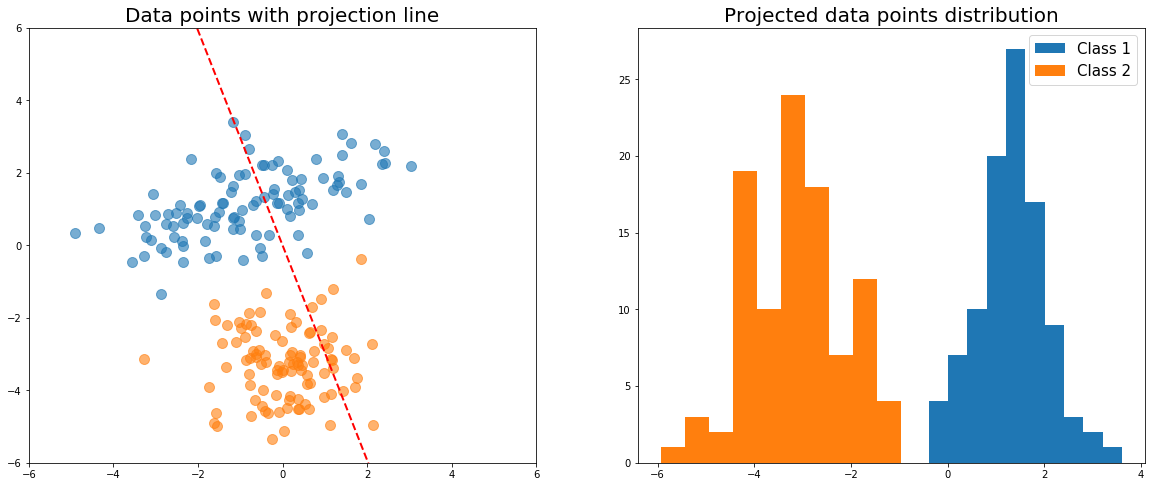

In [336]:
NUM_C_F = 100
def fisher_2C_plot(C_1, C_2, ax):
    S_W = (np.cov(C_1.T) + np.cov(C_2.T)) * (NUM_C_F-1)
    m_1, m_2 = C_1.mean(axis = 0), C_2.mean(axis = 0)
    w_tmp = np.linalg.inv(S_W).dot(m_1-m_2)
    w = w_tmp/np.linalg.norm(w_tmp)
    k = w[1]/w[0]
    ax.scatter(C_1.T[0], C_1.T[1], s = 100, alpha = 0.6)
    ax.scatter(C_2.T[0], C_2.T[1], s = 100, alpha = 0.6)
    ax.plot(np.arange(-5, 5, 0.1), k*np.arange(-5, 5, 0.1), c ="r", linestyle = "dashed", linewidth = 2 )
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,6)
    ax.set_title("Data points with projection line", fontsize = 20)
    return w

def projection_2D_plot(C_1, C_2, w, ax):
    ax.hist(C_1.dot(w))
    ax.hist(C_2.dot(w))
    ax.set_title("Projected data points distribution", fontsize = 20)
    ax.legend(["Class 1", "Class 2"], fontsize = 15)

fig, axes = plt.subplots(1, 2, figsize = (20,8))
C_1 = np.random.multivariate_normal([-1,1], [[3,1],[1,1]] , NUM_C_F)
C_2 = np.random.multivariate_normal([0,-3], [[1,0],[0,1]] , NUM_C_F)
w = fisher_2C_plot(C_1, C_2, axes[0])
projection_2D_plot(C_1, C_2, w, axes[1])

## Notice
To sum up this document, two scatters are shown, where the left one cannot be well separated in the lower dimention thus good to use **least squares**, while the right one is well separated in the lower dimention good to use **Fisher discriminant**

In [314]:
C_1 = np.random.multivariate_normal([-1,1], [[3,1],[1,1]] , 50)
C_2 = np.random.multivariate_normal([0,-3], [[3,0],[0,1]] , 50)
C_3 = np.random.multivariate_normal([5,3], [[1,0],[0,1]] , 50)
C_4 = np.random.multivariate_normal([2,-8], [[5,0],[0,1]] , 50)

Text(0.5,1,'Good to Fisher, Bad to Least squares')

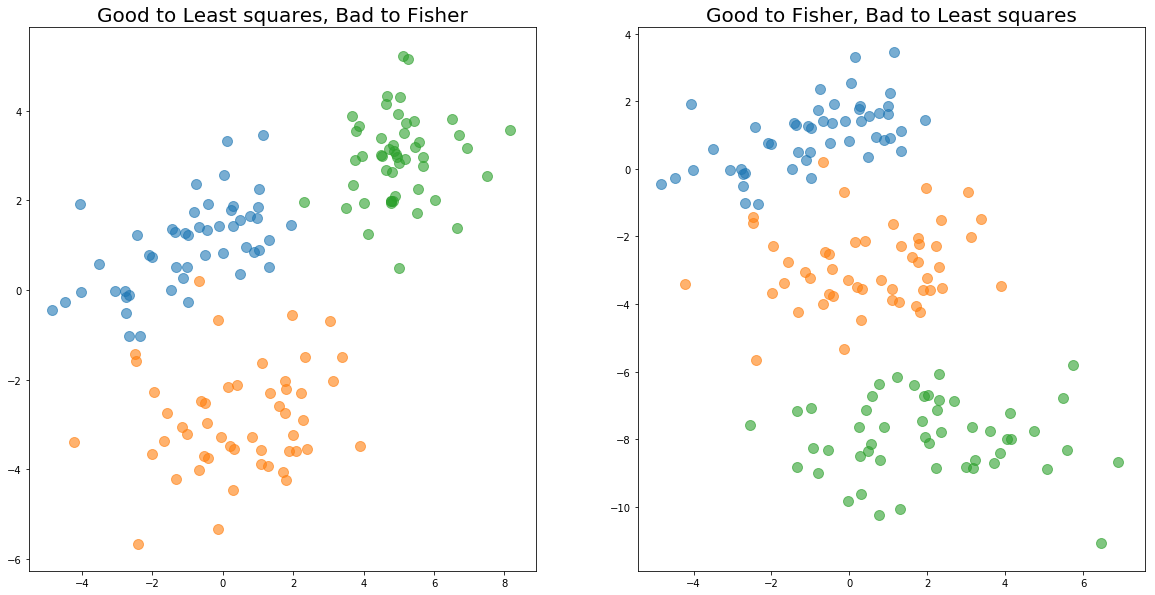

In [317]:
fig, axes = plt.subplots(1, 2, figsize = (20,10))
axes[0].scatter(C_1.T[0], C_1.T[1], s = 100, alpha = 0.6)
axes[0].scatter(C_2.T[0], C_2.T[1], s = 100, alpha = 0.6)
axes[0].scatter(C_3.T[0], C_3.T[1], s = 100, alpha = 0.6)
axes[0].set_title("Good to Least squares, Bad to Fisher", fontsize = 20)

axes[1].scatter(C_1.T[0], C_1.T[1], s = 100, alpha = 0.6)
axes[1].scatter(C_2.T[0], C_2.T[1], s = 100, alpha = 0.6)
axes[1].scatter(C_4.T[0], C_4.T[1], s = 100, alpha = 0.6)
axes[1].set_title("Good to Fisher, Bad to Least squares", fontsize = 20)